In [ ]:
import math
import random
import numpy as np
import time
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
class UAVEnv(object):
  
    height = ground_length = ground_width = 100
    SUM_TASK_SIZE = curr_sum_task_size = 300 * 1048576    # Total computing tasks 500 Mbits
    loc_uav = [50, 50]
    bandwidth_nums = 1
    B = bandwidth_nums * 10 ** 6                          # Bandwidth 1MHz
    p_noisy_los = 10 ** (-13)                             # Noise power -100dBm
    p_noisy_nlos = 10 ** (-11)                            # Noise power -80dBm
    flight_speed = 50.                                    # Flight speed 50m/s
    f_ue = 6e8                                            # UE computing frequency : 0.6GHz
    f_uav = 6e9                                           # UAV computing frequency : 1.2GHz
    r = 10 ** (-27)        
    s = 1000                                              # number of cpu cycles required for unit bit processing is 1000
    p_uplink = 0.1                                        # Uplink transmission power 0.1W
    alpha0 = 1e-5                                         # Reference channel gain at 1m distance -30dB = 0.001, -50dB = 1e-5
    v_ue = 1                                              # ue moving speed 1m/s
    t_fly = 1
    t_com = 5
    m_uav = 9.65                                          # uav mass/kg
    e_battery_uav = 50000000                              # uav battery power: 500kJ. 

    ##### ues #####
    M = 4                                                 # Number of UEs
#     block_flag_list = np.random.randint(0, 2, M)  
    loc_ue_list = np.random.randint(0, 101, size=[M, 2])  # Location information: x is random between 0-100
    task_list = np.random.dirichlet(np.ones(M))*SUM_TASK_SIZE

    action_bound = [-1, 1]                                # Corresponding to the tahn activation function
    action_dim = 4                                        # UE id, flight angle, flight speed, offloading ratio
    #state_dim = 4 + M * 4                                 # uav battery, uav loc, sum task size, ue loc, ue task size, ue block_flag
    state_dim = 4 + M * 3
    
    end_time = np.zeros(M)

    def __init__(self):
        self.update_state()

    def reset_uav(self):
        # print('Resetting UAV')
        self.e_battery_uav = 50000000
        self.loc_uav = [50, 50]
        self.update_state()

    def reset_ue(self):
        # print('Resetting UE')
        self.end_time = np.zeros(M)
        self.task_list = np.random.dirichlet(np.ones(self.M))*self.SUM_TASK_SIZE
        self.curr_sum_task_size = self.SUM_TASK_SIZE
        self.loc_ue_list = np.random.randint(0, 101, size=[self.M, 2])
#         self.block_flag_list = np.random.randint(0, 2, self.M)
        self.update_state()

    def print_state(self):
      print('Battery :', self.e_battery_uav, '\nUAV loc :', self.loc_uav, '\nTask :', self.curr_sum_task_size, self.task_list, '\nUE location :', np.ravel(self.loc_ue_list))#, '\nBlock Flag :', self.block_flag_list)

    def update_state(self):
        # print('Updating State')
        self.state = np.append(self.e_battery_uav, self.loc_uav)
        self.state = np.append(self.state, self.curr_sum_task_size)
        self.state = np.append(self.state, np.ravel(self.loc_ue_list))
        self.state = np.append(self.state, self.task_list)
#         self.state = np.append(self.state, self.block_flag_list)   
    
    def getUENewLoc(self, x, y, dx, dy):

        new_x = (x+dx+2*self.ground_length)%2*self.ground_length
        if new_x > self.ground_length:
            new_x = 2*self.ground_length-new_x
        
        new_y = (y+dy+2*self.ground_width)%2*self.ground_width
        if new_y > self.ground_width:
            new_y = 2*self.ground_width-new_y
        
        return new_x, new_y
    
    def get_offloading_ratio(self, ue_id):
        dx = self.loc_uav[0] - self.loc_ue_list[ue_id][0]
        dy = self.loc_uav[1] - self.loc_ue_list[ue_id][1]
        dh = self.height
        
        dist_uav_ue = np.sqrt(dx * dx + dy * dy + dh * dh)
        p_noise = self.p_noisy_los
        
#         if self.block_flag_list[ue_id] == 1:
#             p_noise = self.p_noisy_nlos
        
        g_uav_ue = abs(self.alpha0 / dist_uav_ue ** 2)
        trans_rate = self.B * math.log2(1 + self.p_uplink * g_uav_ue / p_noise)
        offloading_ratio = (self.s/self.f_ue)/((self.s/self.f_ue) + (self.s/self.f_uav) + (1/trans_rate))
        
        return offloading_ratio
    
    def com_delay(self, offloading_ratio, ue_id):
        dx = self.loc_uav[0] - self.loc_ue_list[ue_id][0]
        dy = self.loc_uav[1] - self.loc_ue_list[ue_id][1]
        dh = self.height
        
        dist_uav_ue = np.sqrt(dx * dx + dy * dy + dh * dh)
        p_noise = self.p_noisy_los
        
#         if self.block_flag_list[ue_id] == 1:
#             p_noise = self.p_noisy_nlos
        
        g_uav_ue = abs(self.alpha0 / dist_uav_ue ** 2)                            # channel gain
        trans_rate = self.B * math.log2(1 + self.p_uplink * g_uav_ue / p_noise)   # Uplink transfer rate bps
        
        task_size = self.task_list[ue_id]
        
        t_tr = offloading_ratio * task_size / trans_rate                          # Upload delay
        t_edge_com = offloading_ratio * task_size / (self.f_uav / self.s)         # Latency calculation on UAV edge server
        t_local_com = (1 - offloading_ratio) * task_size / (self.f_ue / self.s)   # local computing delay
        if t_tr < 0 or t_edge_com < 0 or t_local_com < 0:
            raise Exception(print("+++++++++++++++++!! error !!+++++++++++++++++++++++"))
#         print('--', t_tr, '--', t_edge_com)
        return max([t_tr/10 + t_edge_com, t_local_com])                              # flight time impact factor
    
    def update_task(self, ue_id, computation_ratio):
        if self.task_list[ue_id] != 0:
            self.task_list[ue_id] = (1-computation_ratio)*self.task_list[ue_id]
        
        computation_done = self.t_com*(self.f_ue / self.s)
        
        for i in range(len(self.task_list)):
            if i != ue_id:
                self.task_list[i] = max(0, self.task_list[i]-computation_done)
        
        self.curr_sum_task_size = sum(self.task_list)
        
    def random_movement_ue(self, delay):
        # print('UE Random Movement')
        
        for i in range(self.M):                                                 
            tmp = np.random.rand(2)
            theta_ue = tmp[0] * np.pi * 2                                       # ue random angle
            dis_ue = tmp[1] * delay * self.v_ue                                 # ue random distance
            self.loc_ue_list[i][0] = self.loc_ue_list[i][0] + math.cos(theta_ue) * dis_ue
            self.loc_ue_list[i][1] = self.loc_ue_list[i][1] + math.sin(theta_ue) * dis_ue
            self.loc_ue_list[i] = np.clip(self.loc_ue_list[i], 0, self.ground_width)

    def step(self, action, step):     # 0: UE id, 1: flight angle, 2: flight speed, XX 3: off-loading ratio
        
        action = (action+1)/2
        if action[0] == 1:
            ue_id = self.M - 1
        else:
            ue_id = int(self.M * action[0])
        theta = action[1] * np.pi * 2
        speed = action[2] * self.flight_speed
        # offloading_ratio = self.get_offloading_ratio(ue_id)
        offloading_ratio = action[3]

#         print('UE ID:', ue_id, 'Speed:', speed, 'Angle:', theta, 'Ratio:', offloading_ratio)
        
        b = False
        if self.task_list[ue_id] == 0:
            b = True
        
        task_size = self.task_list[ue_id]
#         block_flag = self.block_flag_list[ue_id]

        # flight distance
        dist_fly = speed * self.t_fly                                             # 1s flight distance
        e_fly = (speed) ** 2 * self.m_uav * self.t_fly * 0.5                      # flight energy

        # Location of UAV after flight
        dx = dist_fly * math.cos(theta)
        dy = dist_fly * math.sin(theta)
        loc_uav_new_x, loc_uav_new_y = self.getUENewLoc(x=self.loc_uav[0], y=self.loc_uav[1], dx=dx, dy=dy)
        self.loc_uav[0] = loc_uav_new_x                                           # UAV location update
        self.loc_uav[1] = loc_uav_new_y
        
        computation_ratio = 0
        if b == False:
            act_delay = self.com_delay(offloading_ratio, ue_id)                       # Computation Delay
            delay = min(self.t_com, act_delay)
            computation_ratio = delay/act_delay

        # Server computing power consumption
        t_server = computation_ratio * offloading_ratio * task_size / (self.f_uav / self.s) # Latency Calculation on UAV
        e_server = self.r * self.f_uav ** 3 * t_server                                      # Computation Energy on UAV

        init_sum = self.curr_sum_task_size
        init_zero = self.task_list.tolist().count(0)

        copy_task_list = np.copy(self.task_list)
        
        self.update_task(ue_id, computation_ratio)

        for i in range(self.M):
            if copy_task_list[i] != 0 and self.task_list[i] == 0:
                self.end_time[i] = step
        
        final_sum = self.curr_sum_task_size
        final_zero = self.task_list.tolist().count(0)
        
        reward = 0
        reward += (init_sum - final_sum)/1000000
        reward += (final_zero - init_zero)*5


        # block_flag_list = np.random.randint(0, 2, self.M)                         # random block after movement                                         
        # self.e_battery_uav = self.e_battery_uav - e_fly - e_server                # Battery remaining 
        self.random_movement_ue(self.t_fly)
        self.update_state()
        
        if b == True:
            reward -= 50
        return self.state, reward, (self.curr_sum_task_size == 0), b
            


In [ ]:

class StateNormalization(object):
    def __init__(self):
        env = UAVEnv()
        M = env.M
        # uav battery remain, uav loc, remaining sum task size, all ue loc, all ue task size, all ue block_flag
        self.high_state = np.array(
            [5e7, env.ground_length, env.ground_width, 300 * 1048576])
        self.high_state = np.append(self.high_state, np.ones(M * 2) * env.ground_length)
        self.high_state = np.append(self.high_state, np.ones(M) * 300 * 1048576)
#         self.high_state = np.append(self.high_state, np.ones(M))
        self.low_state = np.zeros(3 * M + 4)  # uav loc, ue loc, task size, block_flag

    def state_normal(self, state):
        # print('State: ', state)
        return state / (self.high_state - self.low_state)
    

In [ ]:

# MAX_EPISODES = 100
MAX_EPISODES = 25000

LR_A = 0.0001  # learning rate for actor
LR_C = 0.0002  # learning rate for critic
GAMMA = 0.1  # optimal reward discount
TAU = 0.01  # soft replacement
VAR_MIN = 0.01
MEMORY_CAPACITY = 5000
BATCH_SIZE = 64
OUTPUT_GRAPH = False
MAX_EP_STEPS = 200


In [ ]:

def eval_policy(ddpg, eval_episodes=10):
    # eval_env = gym.make(env_name)
    eval_env = UAVEnv()
    # eval_env.seed(seed + 100)
    avg_reward = 0.
    for i in range(eval_episodes):
        state = eval_env.reset()
        # while not done:
        for j in range(int(len(eval_env.UE_loc_list))):
            action = ddpg.choose_action(state)
            action = np.clip(action, *a_bound)
            state, reward = eval_env.step(action)
            avg_reward += reward

    avg_reward /= eval_episodes
    print("---------------------------------------")
    print(f"Evaluation over {eval_episodes} episodes: {avg_reward:.3f}")
    print("---------------------------------------")
    return avg_reward


In [ ]:

class DDPG(object):
    def __init__(self, a_dim, s_dim, a_bound):
        self.count = 0
        
        self.memory = np.zeros((MEMORY_CAPACITY, s_dim * 2 + a_dim + 1), dtype=np.float32)  # memory里存放当前和下一个state，动作和奖励
        self.pointer = 0
        self.sess = tf.Session()

        self.a_dim, self.s_dim, self.a_bound = a_dim, s_dim, a_bound,
        self.S = tf.placeholder(tf.float32, [None, s_dim], 's')  # 输入
        self.S_ = tf.placeholder(tf.float32, [None, s_dim], 's_')
        self.R = tf.placeholder(tf.float32, [None, 1], 'r')

        with tf.variable_scope('Actor'):
            self.a = self._build_a(self.S, scope='eval', trainable=True)
            a_ = self._build_a(self.S_, scope='target', trainable=False)
        with tf.variable_scope('Critic'):
            # assign self.a = a in memory when calculating q for td_error,
            # otherwise the self.a is from Actor when updating Actor
            q = self._build_c(self.S, self.a, scope='eval', trainable=True)
            q_ = self._build_c(self.S_, a_, scope='target', trainable=False)

        self.ae_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Actor/eval')
        self.at_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Actor/target')
        self.ce_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Critic/eval')
        self.ct_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Critic/target')

        # target net replacement
        self.soft_replace = [tf.assign(t, (1 - TAU) * t + TAU * e)
                             for t, e in zip(self.at_params + self.ct_params, self.ae_params + self.ce_params)]

        q_target = self.R + GAMMA * q_
        # in the feed_dic for the td_error, the self.a should change to actions in memory
        td_error = tf.losses.mean_squared_error(labels=q_target, predictions=q)
        self.ctrain = tf.train.AdamOptimizer(LR_C).minimize(td_error, var_list=self.ce_params)

        a_loss = - tf.reduce_mean(q)  # maximize the q
        self.atrain = tf.train.AdamOptimizer(LR_A).minimize(a_loss, var_list=self.ae_params)

        self.sess.run(tf.global_variables_initializer())

        if OUTPUT_GRAPH:
            tf.summary.FileWriter("logs/", self.sess.graph)

    def choose_action(self, s):
        temp = self.sess.run(self.a, {self.S: s[np.newaxis, :]})
        return temp[0]

    def learn(self):
        self.sess.run(self.soft_replace)

        indices = np.random.choice(MEMORY_CAPACITY, size=BATCH_SIZE)
        bt = self.memory[indices, :]
        bs = bt[:, :self.s_dim]
        ba = bt[:, self.s_dim: self.s_dim + self.a_dim]
        br = bt[:, -self.s_dim - 1: -self.s_dim]
        bs_ = bt[:, -self.s_dim:]

        self.sess.run(self.atrain, {self.S: bs})
        self.sess.run(self.ctrain, {self.S: bs, self.a: ba, self.R: br, self.S_: bs_})

    def store_transition(self, s, a, r, s_, b, i):
        
        if b == True:
            self.count += 1
            if(self.count%10 != 0):
                return
#             if(i < 10000 and self.count%10 != 0):
#                 return
#             if(i >= 10000 and self.count%5 != 0):
#                 return
            
        transition = np.hstack((s, a, [r], s_))
        # transition = np.hstack((s, [a], [r], s_))
        index = self.pointer % MEMORY_CAPACITY  # replace the old memory with new memory
        self.memory[index, :] = transition
        self.pointer += 1

    def _build_a(self, s, scope, trainable):
        with tf.variable_scope(scope):
            net = tf.layers.dense(s, 400, activation=tf.nn.relu6, name='l1', trainable=trainable)
            net = tf.layers.dense(net, 300, activation=tf.nn.relu6, name='l2', trainable=trainable)
            net = tf.layers.dense(net, 10, activation=tf.nn.relu, name='l3', trainable=trainable)
            a = tf.layers.dense(net, self.a_dim, activation=tf.nn.tanh, name='a', trainable=trainable)
            return tf.multiply(a, self.a_bound[1], name='scaled_a')

    def _build_c(self, s, a, scope, trainable):
        with tf.variable_scope(scope):
            n_l1 = 400
            w1_s = tf.get_variable('w1_s', [self.s_dim, n_l1], trainable=trainable)
            w1_a = tf.get_variable('w1_a', [self.a_dim, n_l1], trainable=trainable)
            b1 = tf.get_variable('b1', [1, n_l1], trainable=trainable)
            net = tf.nn.relu6(tf.matmul(s, w1_s) + tf.matmul(a, w1_a) + b1)
            net = tf.layers.dense(net, 300, activation=tf.nn.relu6, name='l2', trainable=trainable)
            net = tf.layers.dense(net, 10, activation=tf.nn.relu, name='l3', trainable=trainable)
            return tf.layers.dense(net, 1, trainable=trainable)  # Q(s,a)
    

In [ ]:

np.random.seed(1)
tf.set_random_seed(1)

env = UAVEnv()
s_dim = env.state_dim
a_dim = env.action_dim
a_bound = env.action_bound  # [-1,1]

ddpg = DDPG(int(a_dim), int(s_dim), a_bound)

var = 0.2  # control exploration
t1 = time.time()
ep_reward_list = []
s_normal = StateNormalization()


<ipython-input-7-32176ea0fc30>:81: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  net = tf.layers.dense(s, 400, activation=tf.nn.relu6, name='l1', trainable=trainable)
<ipython-input-7-32176ea0fc30>:82: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  net = tf.layers.dense(net, 300, activation=tf.nn.relu6, name='l2', trainable=trainable)
<ipython-input-7-32176ea0fc30>:83: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  net = tf.layers.dense(net, 10, activation=tf.nn.relu, name='l3', trainable=trainable)
<ipython-input-7-32176ea0fc30>:84: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  a = tf.layers.dense(net, self.a_dim, activation=tf.nn.tanh, name='a', tr

In [ ]:

rewards = []
steps = []
average_delay = []
actual_delay = []

for i in range(MAX_EPISODES):
    env.reset_ue()
    env.reset_uav()
    s = env.state
    ep_reward = 0
    actual_delay.append((max(env.task_list) / (env.f_ue / env.s))/env.t_com)

    is_terminal = False
    step = 0
    
    # while ep_reward < 300 * 1048576 and is_terminal == False and step < MAX_EP_STEPS:
    while is_terminal == False and step < MAX_EP_STEPS:

        # env.print_state()
        a = ddpg.choose_action(s_normal.state_normal(s))
        a = np.clip(np.random.normal(a, var), *a_bound)
        s_, r, is_terminal, b = env.step(a, step)
#         print('Reward:', r)
        # print('\n')
        rewards.append(r)
        
        ddpg.store_transition(s_normal.state_normal(s), a, r, s_normal.state_normal(s_), b, i)

        if ddpg.pointer > MEMORY_CAPACITY:
            var = max([var * 0.99997, VAR_MIN])  # decay the action randomness
            # print('learning')
            ddpg.learn()
        
        s = s_
        ep_reward += r
        step += 1

    steps.append(step)
    average_delay.append(env.end_time.mean())
    print(i)
#     print(i, env.end_time.mean())
    # print('Episode Reward', ep_reward)


Streaming output truncated to the last 5000 lines.
20000
20001
20002
20003
20004
20005
20006
20007
20008
20009
20010
20011
20012
20013
20014
20015
20016
20017
20018
20019
20020
20021
20022
20023
20024
20025
20026
20027
20028
20029
20030
20031
20032
20033
20034
20035
20036
20037
20038
20039
20040
20041
20042
20043
20044
20045
20046
20047
20048
20049
20050
20051
20052
20053
20054
20055
20056
20057
20058
20059
20060
20061
20062
20063
20064
20065
20066
20067
20068
20069
20070
20071
20072
20073
20074
20075
20076
20077
20078
20079
20080
20081
20082
20083
20084
20085
20086
20087
20088
20089
20090
20091
20092
20093
20094
20095
20096
20097
20098
20099
20100
20101
20102
20103
20104
20105
20106
20107
20108
20109
20110
20111
20112
20113
20114
20115
20116
20117
20118
20119
20120
20121
20122
20123
20124
20125
20126
20127
20128
20129
20130
20131
20132
20133
20134
20135
20136
20137
20138
20139
20140
20141
20142
20143
20144
20145
20146
20147
20148
20149
20150
20151
20152
20153
20154
20155
20156
20157
2

Text(0, 0.5, 'Average Time Delay')

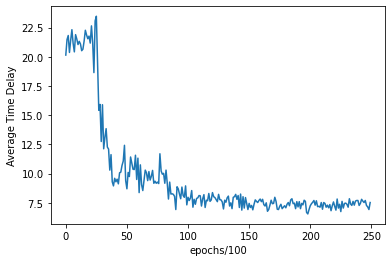

In [ ]:
res = []
for i in range(250):
    res.append(np.array(average_delay[i*10:i*10+10]).mean())
plt.plot(res)
plt.xlabel('epochs/100')
plt.ylabel('Average Time Delay')

Text(0, 0.5, 'Average Steps')

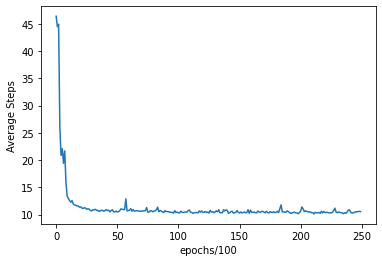

In [ ]:
res = []
for i in range(250):
    res.append(np.array(steps[i*100:i*100+100]).mean())
plt.plot(res)
plt.xlabel('epochs/100')
plt.ylabel('Average Steps')